<a href="https://colab.research.google.com/github/ShreyPandit/Lipschitz/blob/master/Cifar_100_Adam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import keras
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, BatchNormalization
from keras.layers import Activation, AveragePooling2D, Flatten
from keras.models import Model
from keras.optimizers import Adam
from keras.datasets import cifar100
from keras.regularizers import l2
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
from tqdm import tqdm
import pickle
import os
import numpy as np
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

import keras
import keras.backend as K
from keras.datasets import cifar100
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization, Flatten, GlobalMaxPooling2D, GlobalAveragePooling2D
from keras.optimizers import Adam, SGD
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical

import albumentations as albu
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.metrics import accuracy_score
!pip install tensorflow==1.14.0

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarn

In [4]:
batch_size = 256
num_classes = 100
epochs = 20
img_rows, img_cols = 32, 32
lrs=[]
n = 3
depth = n * 9 + 2
input_shape = x_train.shape[1:]

In [3]:
(x_train, y_train), (x_test, y_test) = cifar100.load_data()
x_train=x_train[:10000]
y_train=y_train[:10000]
x_test=x_test[:2000]
y_test=y_test[:2000]

169009152/169001437 [==============================] - 11s 0us/step


In [5]:
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

In [6]:
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [7]:
def resnet_layer(inputs,
                 num_filters=16,
                 kernel_size=3,
                 strides=1,
                 activation='relu',
                 batch_normalization=True,
                 conv_first=True):
    conv = Conv2D(num_filters,
                  kernel_size=kernel_size,
                  strides=strides,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))

    x = inputs
    if conv_first:
        x = conv(x)
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
    else:
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
        x = conv(x)
    return x

In [8]:
def resnet_v2(input_shape, depth, num_classes=100):

    if (depth - 2) % 9 != 0:
        raise ValueError('depth should be 9n+2 (eg 56 or 110 in [b])')

    num_filters_in = 16
    num_res_blocks = int((depth - 2) / 9)

    inputs = Input(shape=input_shape)

    x = resnet_layer(inputs=inputs,
                     num_filters=num_filters_in,
                     conv_first=True)


    for stage in range(3):
        for res_block in range(num_res_blocks):
            activation = 'relu'
            batch_normalization = True
            strides = 1
            if stage == 0:
                num_filters_out = num_filters_in * 4
                if res_block == 0:
                    activation = None
                    batch_normalization = True
            else:
                num_filters_out = num_filters_in * 2
                if res_block == 0: 
                    strides = 2  


            y = resnet_layer(inputs=x,
                             num_filters=num_filters_in,
                             kernel_size=1,
                             strides=strides,
                             activation=activation,
                             batch_normalization=batch_normalization,
                             conv_first=False)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters_in,
                             conv_first=False)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters_out,
                             kernel_size=1,
                             conv_first=False)
            if res_block == 0:
                
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters_out,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=True)
            x = keras.layers.add([x, y])

        num_filters_in = num_filters_out

    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = AveragePooling2D(pool_size=8)(x)
    y = Flatten()(x)
    outputs = Dense(num_classes,
                    activation='softmax',
                    kernel_initializer='he_normal')(y)

    model = Model(inputs=inputs, outputs=outputs)
    return model

In [9]:
model = resnet_v2(input_shape=input_shape, depth=depth)

In [10]:
def lr_schedule(epoch):
    """Learning Rate Schedule
    # Arguments
        epoch (int): The number of epochs
    # Returns
        lr (float32): learning rate
    """
    global K1, K2

    Kz = 0.
    S = 0.
    
    sess = K.get_session()
    max_wt = 0.
    print('Computing max_wt...')
    for weight in model.weights:
        norm = np.linalg.norm(weight.eval(sess))
        if norm > max_wt:
            max_wt = norm
    print('max_wt =', max_wt)
    
    for i in tqdm(range((len(x_train) - 1) // batch_size + 1)):
        start_i = i * batch_size
        end_i = start_i + batch_size
        xb = x_train[start_i:end_i]
    	
        tmp = np.array(func([xb]))
        activ = np.linalg.norm(tmp)
        sq = np.linalg.norm(np.square(tmp))

        if sq > S:
            S = sq
        
        if activ > Kz:
            Kz = activ

    K_ = ((num_classes - 1) * Kz) / (num_classes * batch_size)
    S_ = (num_classes - 1) ** 2 / (num_classes * batch_size) ** 2 * S
    
    K1 = beta1 * K1 + (1 - beta1) * K_
    K2 = beta2 * K2 + (1 - beta2) * S_

    lr = (np.sqrt(K2) + K.epsilon()) / K1
    lrs.append(lr)
    print('Epoch', epoch+1, 'LR =', lr,' K1= ',K1,' K2= ',K2)
    return lr

In [11]:
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(0.1, decay=0.01),
              metrics=['accuracy'])

In [12]:
lr_scheduler = LearningRateScheduler(lr_schedule)

In [13]:
func = K.function([model.layers[0].input], [model.layers[-2].output])
lrs = []
K1 = 0.
K2 = 0.
beta1 = 0.9
beta2 = 0.999

In [14]:
save_dir = '.'

model_name = 'cifar100_model.{epoch:03d}.h5'

filepath = os.path.join(save_dir, model_name)

# Prepare callbacks for model saving and for learning rate adjustment.
checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='accuracy',
                             verbose=1,
                             save_best_only=True,
                             period=1)

In [17]:
history=model.fit(x_train,y_train,batch_size=128,epochs=50,validation_data=(x_test,y_test),callbacks=[lr_scheduler,checkpoint])

Train on 10000 samples, validate on 2000 samples
Epoch 1/50
Computing max_wt...


  0%|          | 0/40 [00:00<?, ?it/s]

max_wt = 677.57385


100%|██████████| 40/40 [02:21<00:00,  3.55s/it]


Epoch 1 LR = 0.03625866570575134  K1=  0.03811465680599212  K2=  1.909610574203545e-06
10000/10000 [==============================] - 616s 62ms/step - loss: 3.5945 - accuracy: 0.2661 - val_loss: 15.2225 - val_accuracy: 0.0690

Epoch 00001: accuracy improved from -inf to 0.26610, saving model to ./cifar100_model.001.h5


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch 2/50
Computing max_wt...
max_wt = 1204.2239


100%|██████████| 40/40 [02:19<00:00,  3.50s/it]


Epoch 2 LR = 0.03542379250355329  K1=  0.10778212577104565  K2=  1.4576754869738536e-05
10000/10000 [==============================] - 580s 58ms/step - loss: 2.7583 - accuracy: 0.3897 - val_loss: 3.8394 - val_accuracy: 0.2455

Epoch 00002: accuracy improved from 0.26610 to 0.38970, saving model to ./cifar100_model.002.h5


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch 3/50
Computing max_wt...
max_wt = 1307.4545


100%|██████████| 40/40 [02:13<00:00,  3.33s/it]


Epoch 3 LR = 0.031938481043927006  K1=  0.12517244356870647  K2=  1.598174693794884e-05
10000/10000 [==============================] - 560s 56ms/step - loss: 2.4241 - accuracy: 0.4502 - val_loss: 3.8488 - val_accuracy: 0.2065

Epoch 00003: accuracy improved from 0.38970 to 0.45020, saving model to ./cifar100_model.003.h5


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch 4/50
Computing max_wt...
max_wt = 1238.7178


100%|██████████| 40/40 [02:10<00:00,  3.27s/it]


Epoch 4 LR = 0.03013159625904433  K1=  0.13674000265896316  K2=  1.6975179122203722e-05
10000/10000 [==============================] - 567s 57ms/step - loss: 2.1907 - accuracy: 0.5044 - val_loss: 3.4118 - val_accuracy: 0.2725

Epoch 00004: accuracy improved from 0.45020 to 0.50440, saving model to ./cifar100_model.004.h5


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch 5/50
Computing max_wt...
max_wt = 1143.2845


100%|██████████| 40/40 [02:18<00:00,  3.47s/it]


Epoch 5 LR = 0.029085320925417126  K1=  0.1461011535170674  K2=  1.805654146123756e-05
10000/10000 [==============================] - 591s 59ms/step - loss: 2.0130 - accuracy: 0.5395 - val_loss: 3.3667 - val_accuracy: 0.2765

Epoch 00005: accuracy improved from 0.50440 to 0.53950, saving model to ./cifar100_model.005.h5


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch 6/50
Computing max_wt...
max_wt = 1045.1288


100%|██████████| 40/40 [02:19<00:00,  3.50s/it]


Epoch 6 LR = 0.027940816281693932  K1=  0.156278145722419  K2=  1.9065789178078644e-05
10000/10000 [==============================] - 592s 59ms/step - loss: 1.8515 - accuracy: 0.5921 - val_loss: 3.4256 - val_accuracy: 0.2845

Epoch 00006: accuracy improved from 0.53950 to 0.59210, saving model to ./cifar100_model.006.h5


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch 7/50
Computing max_wt...
max_wt = 964.2476


100%|██████████| 40/40 [02:19<00:00,  3.49s/it]


Epoch 7 LR = 0.0268881964943133  K1=  0.16756023762691316  K2=  2.0297661357067112e-05
10000/10000 [==============================] - 596s 60ms/step - loss: 1.7195 - accuracy: 0.6251 - val_loss: 3.2826 - val_accuracy: 0.2835

Epoch 00007: accuracy improved from 0.59210 to 0.62510, saving model to ./cifar100_model.007.h5


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch 8/50
Computing max_wt...
max_wt = 890.724


100%|██████████| 40/40 [02:19<00:00,  3.49s/it]


Epoch 8 LR = 0.025978036830598895  K1=  0.17804840405048397  K2=  2.1392919043491674e-05
10000/10000 [==============================] - 585s 58ms/step - loss: 1.5944 - accuracy: 0.6609 - val_loss: 3.2857 - val_accuracy: 0.2890

Epoch 00008: accuracy improved from 0.62510 to 0.66090, saving model to ./cifar100_model.008.h5


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch 9/50
Computing max_wt...
max_wt = 834.3103


100%|██████████| 40/40 [02:17<00:00,  3.43s/it]


Epoch 9 LR = 0.02530849965657626  K1=  0.18777472739751458  K2=  2.2583372751766486e-05
10000/10000 [==============================] - 580s 58ms/step - loss: 1.4840 - accuracy: 0.6867 - val_loss: 3.2372 - val_accuracy: 0.2990

Epoch 00009: accuracy improved from 0.66090 to 0.68670, saving model to ./cifar100_model.009.h5


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch 10/50
Computing max_wt...
max_wt = 784.5527


100%|██████████| 40/40 [02:16<00:00,  3.41s/it]


Epoch 10 LR = 0.024502191493059346  K1=  0.19954640727044928  K2=  2.390451408647056e-05
10000/10000 [==============================] - 578s 58ms/step - loss: 1.3730 - accuracy: 0.7244 - val_loss: 3.2204 - val_accuracy: 0.3150

Epoch 00010: accuracy improved from 0.68670 to 0.72440, saving model to ./cifar100_model.010.h5


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch 11/50
Computing max_wt...
max_wt = 736.70337


100%|██████████| 40/40 [02:14<00:00,  3.36s/it]


Epoch 11 LR = 0.02382946304389381  K1=  0.21136662805797268  K2=  2.5367875981082724e-05
10000/10000 [==============================] - 570s 57ms/step - loss: 1.3126 - accuracy: 0.7429 - val_loss: 3.2707 - val_accuracy: 0.3010

Epoch 00011: accuracy improved from 0.72440 to 0.74290, saving model to ./cifar100_model.011.h5


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch 12/50
Computing max_wt...
max_wt = 699.0388


100%|██████████| 40/40 [02:13<00:00,  3.35s/it]


Epoch 12 LR = 0.023268558281095662  K1=  0.22284556947399625  K2=  2.6886248442734707e-05
10000/10000 [==============================] - 575s 58ms/step - loss: 1.2072 - accuracy: 0.7775 - val_loss: 3.2792 - val_accuracy: 0.3170

Epoch 00012: accuracy improved from 0.74290 to 0.77750, saving model to ./cifar100_model.012.h5


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch 13/50
Computing max_wt...
max_wt = 668.9082


100%|██████████| 40/40 [02:15<00:00,  3.39s/it]


Epoch 13 LR = 0.02276922941925026  K1=  0.23417133354171618  K2=  2.8428099950275574e-05
10000/10000 [==============================] - 578s 58ms/step - loss: 1.1560 - accuracy: 0.7940 - val_loss: 3.2808 - val_accuracy: 0.3170

Epoch 00013: accuracy improved from 0.77750 to 0.79400, saving model to ./cifar100_model.013.h5


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch 14/50
Computing max_wt...
max_wt = 642.5995


100%|██████████| 40/40 [02:17<00:00,  3.43s/it]


Epoch 14 LR = 0.022298729430067173  K1=  0.24584644838891478  K2=  3.005192309135547e-05
10000/10000 [==============================] - 580s 58ms/step - loss: 1.0747 - accuracy: 0.8218 - val_loss: 3.3356 - val_accuracy: 0.3190

Epoch 00014: accuracy improved from 0.79400 to 0.82180, saving model to ./cifar100_model.014.h5


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch 15/50
Computing max_wt...
max_wt = 617.4398


100%|██████████| 40/40 [02:16<00:00,  3.41s/it]


Epoch 15 LR = 0.02190791911233468  K1=  0.25744983552147793  K2=  3.1810617149288225e-05
10000/10000 [==============================] - 586s 59ms/step - loss: 1.0158 - accuracy: 0.8413 - val_loss: 3.3900 - val_accuracy: 0.3195

Epoch 00015: accuracy improved from 0.82180 to 0.84130, saving model to ./cifar100_model.015.h5


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch 16/50
Computing max_wt...
max_wt = 600.81696


100%|██████████| 40/40 [02:21<00:00,  3.53s/it]


Epoch 16 LR = 0.021569695475287875  K1=  0.26877969761118153  K2=  3.360980301762417e-05
10000/10000 [==============================] - 600s 60ms/step - loss: 0.9514 - accuracy: 0.8584 - val_loss: 3.3392 - val_accuracy: 0.3150

Epoch 00016: accuracy improved from 0.84130 to 0.85840, saving model to ./cifar100_model.016.h5


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch 17/50
Computing max_wt...
max_wt = 581.403


100%|██████████| 40/40 [02:22<00:00,  3.55s/it]


Epoch 17 LR = 0.02132105090066688  K1=  0.27919746627889447  K2=  3.543443954002863e-05
10000/10000 [==============================] - 599s 60ms/step - loss: 0.9126 - accuracy: 0.8688 - val_loss: 3.4667 - val_accuracy: 0.3145

Epoch 00017: accuracy improved from 0.85840 to 0.86880, saving model to ./cifar100_model.017.h5


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch 18/50
Computing max_wt...
max_wt = 565.16833


100%|██████████| 40/40 [02:22<00:00,  3.57s/it]


Epoch 18 LR = 0.02100660802575962  K1=  0.2911706772787783  K2=  3.741045032337674e-05
10000/10000 [==============================] - 603s 60ms/step - loss: 0.8682 - accuracy: 0.8865 - val_loss: 3.5515 - val_accuracy: 0.3010

Epoch 00018: accuracy improved from 0.86880 to 0.88650, saving model to ./cifar100_model.018.h5


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch 19/50
Computing max_wt...
max_wt = 550.1835


100%|██████████| 40/40 [02:23<00:00,  3.59s/it]


Epoch 19 LR = 0.02081135573107445  K1=  0.30155694225520613  K2=  3.9384520922919784e-05
10000/10000 [==============================] - 609s 61ms/step - loss: 0.8212 - accuracy: 0.8998 - val_loss: 3.5268 - val_accuracy: 0.3100

Epoch 00019: accuracy improved from 0.88650 to 0.89980, saving model to ./cifar100_model.019.h5


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch 20/50
Computing max_wt...
max_wt = 534.9133


100%|██████████| 40/40 [02:24<00:00,  3.62s/it]


Epoch 20 LR = 0.020634755021071025  K1=  0.3121518631794219  K2=  4.14874758323039e-05
10000/10000 [==============================] - 606s 61ms/step - loss: 0.7926 - accuracy: 0.9086 - val_loss: 3.5340 - val_accuracy: 0.3155

Epoch 00020: accuracy improved from 0.89980 to 0.90860, saving model to ./cifar100_model.020.h5


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch 21/50
Computing max_wt...
max_wt = 520.51855


100%|██████████| 40/40 [02:23<00:00,  3.58s/it]


Epoch 21 LR = 0.020495687752127588  K1=  0.3221105016784219  K2=  4.358344984099788e-05
10000/10000 [==============================] - 600s 60ms/step - loss: 0.7559 - accuracy: 0.9191 - val_loss: 3.5396 - val_accuracy: 0.3160

Epoch 00021: accuracy improved from 0.90860 to 0.91910, saving model to ./cifar100_model.021.h5


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch 22/50
Computing max_wt...
max_wt = 508.42316


100%|██████████| 40/40 [02:21<00:00,  3.53s/it]


Epoch 22 LR = 0.020430508743608793  K1=  0.33095790566650163  K2=  4.571840133839947e-05
10000/10000 [==============================] - 592s 59ms/step - loss: 0.7299 - accuracy: 0.9281 - val_loss: 3.5574 - val_accuracy: 0.3285

Epoch 00022: accuracy improved from 0.91910 to 0.92810, saving model to ./cifar100_model.022.h5


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch 23/50
Computing max_wt...
max_wt = 495.53015


100%|██████████| 40/40 [02:18<00:00,  3.45s/it]


Epoch 23 LR = 0.020380311869482252  K1=  0.3395745202450198  K2=  4.789379950306717e-05
10000/10000 [==============================] - 586s 59ms/step - loss: 0.7129 - accuracy: 0.9329 - val_loss: 3.6885 - val_accuracy: 0.3215

Epoch 00023: accuracy improved from 0.92810 to 0.93290, saving model to ./cifar100_model.023.h5


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch 24/50
Computing max_wt...
max_wt = 484.9944


100%|██████████| 40/40 [02:17<00:00,  3.44s/it]


Epoch 24 LR = 0.02033250035006804  K1=  0.3479660846783139  K2=  5.005450062656489e-05
10000/10000 [==============================] - 579s 58ms/step - loss: 0.6811 - accuracy: 0.9421 - val_loss: 3.6285 - val_accuracy: 0.3150

Epoch 00024: accuracy improved from 0.93290 to 0.94210, saving model to ./cifar100_model.024.h5


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch 25/50
Computing max_wt...
max_wt = 476.02765


100%|██████████| 40/40 [02:17<00:00,  3.43s/it]


Epoch 25 LR = 0.02031453932838037  K1=  0.3557789418691472  K2=  5.223509837309806e-05
10000/10000 [==============================] - 586s 59ms/step - loss: 0.6563 - accuracy: 0.9482 - val_loss: 3.7017 - val_accuracy: 0.3155

Epoch 00025: accuracy improved from 0.94210 to 0.94820, saving model to ./cifar100_model.025.h5


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch 26/50
Computing max_wt...
max_wt = 466.0772


100%|██████████| 40/40 [02:18<00:00,  3.45s/it]


Epoch 26 LR = 0.02028826776950062  K1=  0.36413473414725744  K2=  5.457608693942502e-05
10000/10000 [==============================] - 582s 58ms/step - loss: 0.6257 - accuracy: 0.9590 - val_loss: 3.7499 - val_accuracy: 0.3080

Epoch 00026: accuracy improved from 0.94820 to 0.95900, saving model to ./cifar100_model.026.h5


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch 27/50
Computing max_wt...
max_wt = 458.32617


100%|██████████| 40/40 [02:14<00:00,  3.37s/it]


Epoch 27 LR = 0.020278958722249746  K1=  0.3722234124304058  K2=  5.6975371792012524e-05
10000/10000 [==============================] - 577s 58ms/step - loss: 0.6152 - accuracy: 0.9599 - val_loss: 3.8120 - val_accuracy: 0.3095

Epoch 00027: accuracy improved from 0.95900 to 0.95990, saving model to ./cifar100_model.027.h5


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch 28/50
Computing max_wt...
max_wt = 449.47675


100%|██████████| 40/40 [02:19<00:00,  3.48s/it]


Epoch 28 LR = 0.020281490800087225  K1=  0.38018977317463176  K2=  5.9455131778216586e-05
10000/10000 [==============================] - 587s 59ms/step - loss: 0.5844 - accuracy: 0.9686 - val_loss: 3.7801 - val_accuracy: 0.3100

Epoch 00028: accuracy improved from 0.95990 to 0.96860, saving model to ./cifar100_model.028.h5


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch 29/50
Computing max_wt...
max_wt = 441.9737


100%|██████████| 40/40 [02:18<00:00,  3.47s/it]


Epoch 29 LR = 0.02031720743375058  K1=  0.3871477218858971  K2=  6.186861625058664e-05
10000/10000 [==============================] - 578s 58ms/step - loss: 0.5752 - accuracy: 0.9693 - val_loss: 3.8338 - val_accuracy: 0.3050

Epoch 00029: accuracy improved from 0.96860 to 0.96930, saving model to ./cifar100_model.029.h5


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch 30/50
Computing max_wt...
max_wt = 434.79706


100%|██████████| 40/40 [02:14<00:00,  3.37s/it]


Epoch 30 LR = 0.02035314624261347  K1=  0.39395241553120974  K2=  6.428946458059334e-05
10000/10000 [==============================] - 567s 57ms/step - loss: 0.5566 - accuracy: 0.9730 - val_loss: 3.8787 - val_accuracy: 0.3100

Epoch 00030: accuracy improved from 0.96930 to 0.97300, saving model to ./cifar100_model.030.h5


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch 31/50
Computing max_wt...
max_wt = 427.86743


100%|██████████| 40/40 [02:16<00:00,  3.42s/it]


Epoch 31 LR = 0.020387486313486126  K1=  0.4009427355635151  K2=  6.681614841156353e-05
10000/10000 [==============================] - 579s 58ms/step - loss: 0.5403 - accuracy: 0.9769 - val_loss: 3.8720 - val_accuracy: 0.3155

Epoch 00031: accuracy improved from 0.97300 to 0.97690, saving model to ./cifar100_model.031.h5


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch 32/50
Computing max_wt...
max_wt = 420.5154


100%|██████████| 40/40 [02:18<00:00,  3.46s/it]


Epoch 32 LR = 0.02044316747343076  K1=  0.4073918568409668  K2=  6.936024703736776e-05
10000/10000 [==============================] - 568s 57ms/step - loss: 0.5243 - accuracy: 0.9819 - val_loss: 3.8958 - val_accuracy: 0.3130

Epoch 00032: accuracy improved from 0.97690 to 0.98190, saving model to ./cifar100_model.032.h5


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch 33/50
Computing max_wt...
max_wt = 413.25085


100%|██████████| 40/40 [02:12<00:00,  3.31s/it]


Epoch 33 LR = 0.020494674609774863  K1=  0.41385564935063  K2=  7.193986031254927e-05
10000/10000 [==============================] - 567s 57ms/step - loss: 0.5150 - accuracy: 0.9801 - val_loss: 3.9096 - val_accuracy: 0.3125


  0%|          | 0/40 [00:00<?, ?it/s]


Epoch 00033: accuracy did not improve from 0.98190
Epoch 34/50
Computing max_wt...
max_wt = 406.3822


100%|██████████| 40/40 [02:16<00:00,  3.41s/it]


Epoch 34 LR = 0.020567691371968524  K1=  0.4196427528427959  K2=  7.449386110677995e-05
10000/10000 [==============================] - 578s 58ms/step - loss: 0.4960 - accuracy: 0.9825 - val_loss: 3.9349 - val_accuracy: 0.3150

Epoch 00034: accuracy improved from 0.98190 to 0.98250, saving model to ./cifar100_model.034.h5


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch 35/50
Computing max_wt...
max_wt = 400.08325


100%|██████████| 40/40 [02:11<00:00,  3.28s/it]


Epoch 35 LR = 0.020657269182719738  K1=  0.4249792270988453  K2=  7.706751012966965e-05
10000/10000 [==============================] - 564s 56ms/step - loss: 0.5011 - accuracy: 0.9836 - val_loss: 4.0430 - val_accuracy: 0.3045

Epoch 00035: accuracy improved from 0.98250 to 0.98360, saving model to ./cifar100_model.035.h5


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch 36/50
Computing max_wt...
max_wt = 395.99445


100%|██████████| 40/40 [02:07<00:00,  3.20s/it]


Epoch 36 LR = 0.02071379207606955  K1=  0.4312598859188165  K2=  7.979719564390573e-05
10000/10000 [==============================] - 559s 56ms/step - loss: 0.4822 - accuracy: 0.9875 - val_loss: 4.0470 - val_accuracy: 0.3015

Epoch 00036: accuracy improved from 0.98360 to 0.98750, saving model to ./cifar100_model.036.h5


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch 37/50
Computing max_wt...
max_wt = 390.6765


100%|██████████| 40/40 [02:09<00:00,  3.25s/it]


Epoch 37 LR = 0.02079529994536013  K1=  0.43693642159556195  K2=  8.25576483281296e-05
10000/10000 [==============================] - 534s 53ms/step - loss: 0.4884 - accuracy: 0.9850 - val_loss: 4.0491 - val_accuracy: 0.3045


  0%|          | 0/40 [00:00<?, ?it/s]


Epoch 00037: accuracy did not improve from 0.98750
Epoch 38/50
Computing max_wt...
max_wt = 385.1062


100%|██████████| 40/40 [02:00<00:00,  3.01s/it]


Epoch 38 LR = 0.020891028992925182  K1=  0.44196000972618027  K2=  8.524643090401817e-05
10000/10000 [==============================] - 510s 51ms/step - loss: 0.4711 - accuracy: 0.9876 - val_loss: 4.0915 - val_accuracy: 0.2985

Epoch 00038: accuracy improved from 0.98750 to 0.98760, saving model to ./cifar100_model.038.h5


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch 39/50
Computing max_wt...
max_wt = 380.8336


100%|██████████| 40/40 [01:59<00:00,  2.99s/it]


Epoch 39 LR = 0.02097133541757252  K1=  0.44737500982787637  K2=  8.802101185693133e-05
10000/10000 [==============================] - 532s 53ms/step - loss: 0.4708 - accuracy: 0.9856 - val_loss: 4.0707 - val_accuracy: 0.3005


  0%|          | 0/40 [00:00<?, ?it/s]


Epoch 00039: accuracy did not improve from 0.98760
Epoch 40/50
Computing max_wt...
max_wt = 377.63568


100%|██████████| 40/40 [02:13<00:00,  3.35s/it]


Epoch 40 LR = 0.021079786966868533  K1=  0.45194944844221857  K2=  9.076178727356297e-05
10000/10000 [==============================] - 558s 56ms/step - loss: 0.4635 - accuracy: 0.9878 - val_loss: 4.1111 - val_accuracy: 0.3015

Epoch 00040: accuracy improved from 0.98760 to 0.98780, saving model to ./cifar100_model.040.h5


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch 41/50
Computing max_wt...
max_wt = 373.78864


100%|██████████| 40/40 [02:11<00:00,  3.30s/it]


Epoch 41 LR = 0.021181270444173717  K1=  0.45675608258464145  K2=  9.359738425335276e-05
10000/10000 [==============================] - 562s 56ms/step - loss: 0.4520 - accuracy: 0.9889 - val_loss: 4.1471 - val_accuracy: 0.3015

Epoch 00041: accuracy improved from 0.98780 to 0.98890, saving model to ./cifar100_model.041.h5


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch 42/50
Computing max_wt...
max_wt = 369.10812


100%|██████████| 40/40 [02:13<00:00,  3.33s/it]


Epoch 42 LR = 0.021285742750036227  K1=  0.46152807570414134  K2=  9.650838034684681e-05
10000/10000 [==============================] - 566s 57ms/step - loss: 0.4542 - accuracy: 0.9883 - val_loss: 4.1582 - val_accuracy: 0.2970


  0%|          | 0/40 [00:00<?, ?it/s]


Epoch 00042: accuracy did not improve from 0.98890
Epoch 43/50
Computing max_wt...
max_wt = 364.9511


100%|██████████| 40/40 [02:08<00:00,  3.22s/it]


Epoch 43 LR = 0.02139796777705279  K1=  0.4659456546030914  K2=  9.940469069105028e-05
10000/10000 [==============================] - 557s 56ms/step - loss: 0.4346 - accuracy: 0.9921 - val_loss: 4.1513 - val_accuracy: 0.3005

Epoch 00043: accuracy improved from 0.98890 to 0.99210, saving model to ./cifar100_model.043.h5


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch 44/50
Computing max_wt...
max_wt = 361.08893


100%|██████████| 40/40 [02:13<00:00,  3.33s/it]


Epoch 44 LR = 0.0215243701144991  K1=  0.469830419444067  K2=  0.00010226677893865144
10000/10000 [==============================] - 566s 57ms/step - loss: 0.4193 - accuracy: 0.9938 - val_loss: 4.1420 - val_accuracy: 0.3015

Epoch 00044: accuracy improved from 0.99210 to 0.99380, saving model to ./cifar100_model.044.h5


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch 45/50
Computing max_wt...
max_wt = 357.75507


100%|██████████| 40/40 [02:14<00:00,  3.37s/it]


Epoch 45 LR = 0.02165761745204568  K1=  0.4734462179151381  K2=  0.00010513666305354813
10000/10000 [==============================] - 563s 56ms/step - loss: 0.4079 - accuracy: 0.9957 - val_loss: 4.1792 - val_accuracy: 0.3025

Epoch 00045: accuracy improved from 0.99380 to 0.99570, saving model to ./cifar100_model.045.h5


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch 46/50
Computing max_wt...
max_wt = 353.77692


100%|██████████| 40/40 [02:12<00:00,  3.32s/it]


Epoch 46 LR = 0.021784089501369827  K1=  0.47722063863937897  K2=  0.00010807093410683683
10000/10000 [==============================] - 565s 56ms/step - loss: 0.4167 - accuracy: 0.9922 - val_loss: 4.2413 - val_accuracy: 0.3035


  0%|          | 0/40 [00:00<?, ?it/s]


Epoch 00046: accuracy did not improve from 0.99570
Epoch 47/50
Computing max_wt...
max_wt = 350.15887


100%|██████████| 40/40 [02:06<00:00,  3.16s/it]


Epoch 47 LR = 0.021909399815989862  K1=  0.4810091865479783  K2=  0.00011106045823753769
10000/10000 [==============================] - 553s 55ms/step - loss: 0.4041 - accuracy: 0.9951 - val_loss: 4.2169 - val_accuracy: 0.3025


  0%|          | 0/40 [00:00<?, ?it/s]


Epoch 00047: accuracy did not improve from 0.99570
Epoch 48/50
Computing max_wt...
max_wt = 346.2071


100%|██████████| 40/40 [02:12<00:00,  3.30s/it]


Epoch 48 LR = 0.02205254594166996  K1=  0.4841590884107205  K2=  0.00011399492392202121
10000/10000 [==============================] - 538s 54ms/step - loss: 0.4060 - accuracy: 0.9940 - val_loss: 4.2884 - val_accuracy: 0.2970


  0%|          | 0/40 [00:00<?, ?it/s]


Epoch 00048: accuracy did not improve from 0.99570
Epoch 49/50
Computing max_wt...
max_wt = 343.13998


100%|██████████| 40/40 [02:01<00:00,  3.04s/it]


Epoch 49 LR = 0.022173421919474617  K1=  0.4878995342354046  K2=  0.00011703566307291252
10000/10000 [==============================] - 513s 51ms/step - loss: 0.4079 - accuracy: 0.9934 - val_loss: 4.2939 - val_accuracy: 0.2980


  0%|          | 0/40 [00:00<?, ?it/s]


Epoch 00049: accuracy did not improve from 0.99570
Epoch 50/50
Computing max_wt...
max_wt = 340.21606


100%|██████████| 40/40 [01:57<00:00,  2.94s/it]


Epoch 50 LR = 0.02230507125012282  K1=  0.49123482024372217  K2=  0.00012005426387965452
10000/10000 [==============================] - 496s 50ms/step - loss: 0.4063 - accuracy: 0.9927 - val_loss: 4.2984 - val_accuracy: 0.3035

Epoch 00050: accuracy did not improve from 0.99570


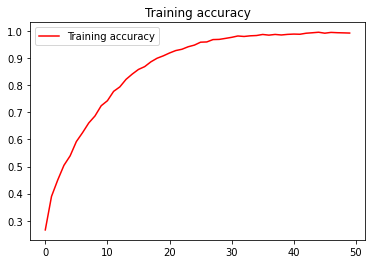

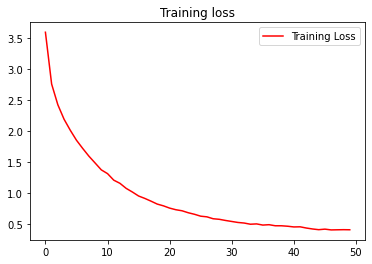

In [18]:
%matplotlib inline
import matplotlib.pyplot as plt
acc = history.history['accuracy']
loss = history.history['loss']
epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.title('Training accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.title('Training loss')
plt.legend()

plt.show()
